# Tutorial

This tutorial shows the basic concept behind *FLooPy*.

## Getting Started

In [1]:
import floopy as fly
from numpy import pi, cos, sin


class Lissajous(fly.Task):
    phi  = fly.loop_items(15, 210, loop_level=1)  # loop (phi, freq) simultaneously
    freq = fly.loop_items( 2, 0.6, loop_level=1)  # ... as outer loop
    t    = fly.loop_lin(0, 2, step=0.02)    # inner loop

    def task_x(t):
        return sin(2 * pi * t)

    def task_y(t, freq, phi):
        return cos(2 * pi * freq * t + phi * pi/180)

In [2]:
dm = fly.DataManager()
dm.run_live(Lissajous)

Output()

File: dm/dm_2024-10-02_20:50:11.json

In [3]:
# Read the results as a pandas-table.
df = dm.read_task(Lissajous)
df

task_x    task_y
phi freq t                           
15  2.0  0.00  0.000000e+00  0.965926
         0.02  1.253332e-01  0.871214
         0.04  2.486899e-01  0.721760
         0.06  3.681246e-01  0.526956
         0.08  4.817537e-01  0.299041
...                     ...       ...
210 0.6  1.92 -4.817537e-01 -0.092023
         1.94 -3.681246e-01 -0.016754
         1.96 -2.486899e-01  0.058609
         1.98 -1.253332e-01  0.133640
         2.00 -4.898587e-16  0.207912

[202 rows x 2 columns]

<AxesSubplot: xlabel='task_x', ylabel='task_y'>

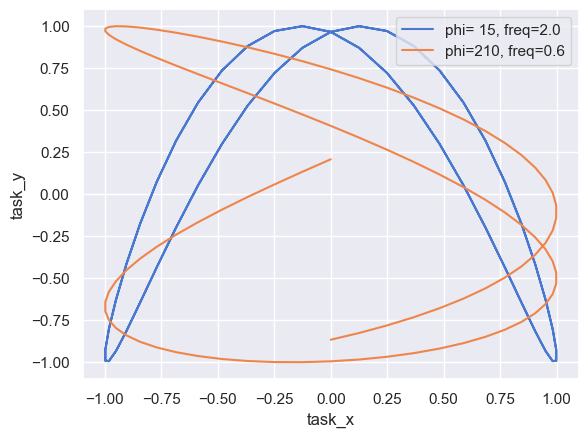

In [4]:
# plot the results with matplotlib/seaborn
import seaborn as sns
sns.set_theme()


df = df.reset_index()
sns.lineplot(
    data=df,
    x='task_x',
    y='task_y',
    hue=[f'{phi=:3}, {freq=}' for phi, freq in zip(df.phi, df.freq)],  # set of curves
    palette='muted',
    sort=False,
    estimator=None,
)

## HV-Loop Sections

In general an experiment can be devided into five **sections**:

1. **Setup**: Initialize all the instrument and prepare the device-under-test (dut)
2. **Task/Test**: Perform one or multiple (measurement) tasks often with loops.
3. **Teardown**: Clean-up
4. **Final**: Analyse the measurement results, e.g. data-fitting, test-report, datasheet or plots   
6. **Return** the relevant (test) results, e.g. pass/fail

In *FLooPy* these steps can be implemented with a `Task` class:

In [5]:
import floopy as fly

In [6]:
class MyTask(fly.Task):
    ### 1. Setup Section ###    
    def setup_1(): ...
    def setup_2(): ...

    ### 2. Task/Test Section ###
    def task_1(): ...
    def task_2(): ...
        
    ### 3. Teardown Section ###
    def teardown_1(): ...
    def teardown_2(): ...
    
    ### 4. Final Section ###
    def final_1(): ...
    def final_2(): ...

    ### 5. Return-Value of MyTask ###
    def __return__(): ...

The numbers `_1` and `_2` should be substituted with meaningfull names. Inside the functions the actual task/test or analysis is performed. 

Every section is optional and can have multiple functions. These functions are evaluated sequentialy.

In order to run the experiment a *DataManager* needed saveing the function results.

In [7]:
dm = fly.DataManager()

In [8]:
dm.run_live(MyTask)

Output()

File: dm/dm_2024-10-02_20:50:25.json

Many experiments need to repeat certain steps. This can be done with *FLooPy*-**Loops** in two ways: 
* Run a *horizontal* loop over the complete second task/test section
* Run a *vertical* loop (locally) over a function argument

In [9]:
class MyTask(fly.Task):
    myoption = fly.loop_items(True, False)
    
    def task_1(x=fly.loop(3, 4, 5)): ...
    def task_2(y=fly.loop('A', 'B')): ...

In [10]:
dm.run_log(MyTask)

[20:50:29]  task_1 | myoption=True, task_1.x=3

[20:50:29]  task_1 | myoption=True, task_1.x=4

[20:50:29]  task_1 | myoption=True, task_1.x=5

[20:50:29]  task_2 | myoption=True, task_2.y='A'

[20:50:29]  task_2 | myoption=True, task_2.y='B'

[20:50:29]  task_1 | myoption=False, task_1.x=3

[20:50:29]  task_1 | myoption=False, task_1.x=4

[20:50:29]  task_1 | myoption=False, task_1.x=5

[20:50:29]  task_2 | myoption=False, task_2.y='A'

[20:50:29]  task_2 | myoption=False, task_2.y='B'

File: dm/dm_2024-10-02_20:50:29.json

The `myoption`-loop behaves like a usual for-loop (written *horizontally*) with the task-section as the loop-body (written *vertically*).

## Loop Configuration

Currently *FLooPy* has four basic loop types:
* `loop_items(item_1, ...)` for looping over a sequence of items
* `loop_lin(start, stop, step=1, num=None)` linear sweep from start to stop with either a fixed step-size or a fixed number of steps.
* `loop_log(start, stop, num)` logarithmic sweep
* `loop_bisect(start, stop, cycles=3)` biset the interval from start to stop within three cycles

*Note:* It is possible to feedback the function-result into the loop enabling real-time optimization or Hardware-in-the-Loop layouts. But this feature is not covered by this tutorial.

### Nested Loops

The default loop configuration for multiple loops is *nesting*

In [11]:
class MyTask(fly.Task):
    x = fly.loop_lin(20, 30, num=3)
    y = fly.loop_log(1, 100, num=3)

    def task(x, y): ...

In [12]:
dm.run_log(MyTask)

[20:50:34]  task | x=20.0, y=1.0

[20:50:34]  task | x=20.0, y=10.0

[20:50:34]  task | x=20.0, y=100.0

[20:50:34]  task | x=25.0, y=1.0

[20:50:34]  task | x=25.0, y=10.0

[20:50:34]  task | x=25.0, y=100.0

[20:50:34]  task | x=30.0, y=1.0

[20:50:34]  task | x=30.0, y=10.0

[20:50:34]  task | x=30.0, y=100.0

File: dm/dm_2024-10-02_20:50:34.json

### Zipped Loops

If both loops should be run simultaneously they must have an equal `loop_level`.

In [13]:
class MyTask(fly.Task):
    x = fly.loop_lin(20, 30, num=3, loop_level=1)
    y = fly.loop_log(1, 100, num=3, loop_level=1)

    def task(x, y): ...

In [14]:
dm.run_log(MyTask)

[20:50:36]  task | x=20.0, y=1.0

[20:50:36]  task | x=25.0, y=10.0

[20:50:36]  task | x=30.0, y=100.0

File: dm/dm_2024-10-02_20:50:36.json

*Note:* In native python it's called `zip(loop_1, ...)`.

### Concatenated Loops

Loops and single values can be concatenated just by `loop(...)`. An up-down sweep is done by

In [15]:
class MyTask(fly.Task):
    x = fly.loop(
        2.5, 
        fly.loop_lin(3, 5), 
        5.5, 
        fly.loop_lin(5, 3), 
        2.5,
    )

    def task(x): ...

In [16]:
dm.run_log(MyTask)

[20:50:38]  task | x=2.5

[20:50:38]  task | x=3

[20:50:38]  task | x=4

[20:50:38]  task | x=5

[20:50:38]  task | x=5.5

[20:50:38]  task | x=5

[20:50:38]  task | x=4

[20:50:39]  task | x=3

[20:50:39]  task | x=2.5

File: dm/dm_2024-10-02_20:50:38.json

## DataManager

So far, we have looped the function arguments in different ways. Now we want to produce real data - the return values of the functions. As an example, we will square the numbers from 2 to 5.

In [17]:
class Square(fly.Task):
    power = 2
    base = fly.loop_lin(2, 5, step=1)
    
    def __return__(base, power):
        return base**power

In [18]:
dm.run_log(Square)

[20:50:40]  Square | base=2

[20:50:40]      = 4

[20:50:40]  Square | base=3

[20:50:40]      = 9

[20:50:40]  Square | base=4

[20:50:40]      = 16

[20:50:40]  Square | base=5

[20:50:40]      = 25

File: dm/dm_2024-10-02_20:50:40.json

The function results can be read either as a tabel (pandas.DataFrame) or as a raw time-list.

### DataFrame Table

In order to show the return values of `Square.__return__` with its arguments just type:

In [19]:
dm.read_task(Square)

,power,__return__
base,,
2,2,4
3,2,9
4,2,16
5,2,25


*Note:* The loops are set as the table-index.

### Raw Time-Signal

The DataManager is basically a large python dictionary storing the arising data during the task-run. In order to save the function values as a **time-signal** the DataManager needs two additional information:
* An **unique name** of the function/variable and
* the value of a **counter** which is increased everytime a function value is stored. The counter values are mapped to timestamps.

In [20]:
dm.read_namespace(Square)

['Square',
 'Square.power',
 'Square.base',
 'Square.base.start',
 'Square.base.stop',
 'Square.base.step']

In [21]:
dm.read_raw('Square.base')

([24, 38, 52, 66], [2, 3, 4, 5])

In [22]:
dm.read_raw('Square')

([27, 40, 54, 68], [4, 9, 16, 25])

The first list stores the current counter value at the moment of writting. The actual loop-values of `Square.base` are stored in the second list.

The counter is mapped to timestamps. For example we can extract the time difference between the last and first value of `Square.base` loop

In [23]:
dm._times[66] - dm._times[24]

Timedelta('0 days 00:00:00.022462')

After each run the DataManager saves the complete data dictionary (loop states, function results, required configuration inputs, ...) and some metadata in a json file.

In [24]:
%head -n 16 dm/dm_2024-10-02_20\:50\:40.json

{"_cnt": 74,
 "_info": {
     "timezone": "America/Asuncion",
     "network": "5c:80:b6:2e:a5:18",
     "arch": "x86_64",
     "hostname": "latitude",
     "system": "Linux",
     "version": "#40~22.04.3-Ubuntu SMP PREEMPT_DYNAMIC Tue Jul 30 17:30:19 UTC 2",
     "release": "6.8.0-40-generic",
     "python": "3.10.12 (main, Sep 11 2024, 15:47:36) [GCC 11.4.0]"},
 "Square": {
     "cnts": [27, 40, 54, 68],
     "vals": [4, 9, 16, 25]},
 "Square.base": {
     "cnts": [24, 38, 52, 66],
     "vals": [2, 3, 4, 5]},


As a consequence of the data-layout it is possible to
* continue an interrupted run (the loop-states are saved)
* use the data for post-processing tasks (`FLooPy.Task`)

*Note:* Even if it's possible to basically show both features they must be further tested and developed.

## Subclassing

Since tasks are classes they can be subclassed from ohter task-classes. For example assume we want to have a task for calculating the square-root by overwritting ´base=1/2´ from the `Square` task.

In [25]:
class SqRoot(Square):
    power = 1/2

In [26]:
dm.run_log(SqRoot)

[20:51:41]  SqRoot | base=2

[20:51:41]      = 1.4142135623730951

[20:51:41]  SqRoot | base=3

[20:51:41]      = 1.7320508075688772

[20:51:41]  SqRoot | base=4

[20:51:41]      = 2.0

[20:51:41]  SqRoot | base=5

[20:51:41]      = 2.23606797749979

File: dm/dm_2024-10-02_20:51:41_SqRoot.json

## Composing Sub-Tasks with Inputs

Tasks can be reused in other tasks building the *big picture* step-by-step. Therefore we need tasks to have inputs. We will demonstrate this by creating a general `Power` task which can be used either for calculating the square or square-root value.

In [27]:
class Power(fly.Task):
    base = fly.Input()
    power = fly.Input(default=1)
                    
    def __return__(base, power):
        return base**power


class SquareRoot(fly.Task):
    x = fly.loop(2, 3, 4)

    task_square = Power(x, 2)

    task_root = Power(x, 1/2)

In [28]:
dm.run_log(SquareRoot)

[20:51:45]  task_square | x=2

[20:51:45]      = 4

[20:51:45]  task_root | x=2

[20:51:45]      = 1.4142135623730951

[20:51:45]  task_square | x=3

[20:51:45]      = 9

[20:51:45]  task_root | x=3

[20:51:45]      = 1.7320508075688772

[20:51:45]  task_square | x=4

[20:51:45]      = 16

[20:51:45]  task_root | x=4

[20:51:45]      = 2.0

File: dm/dm_2024-10-02_20:51:45_SquareRoot.json

In [29]:
dm.read_task(SquareRoot)

,task_square,task_root
x,,
2,4,1.414214
3,9,1.732051
4,16,2.000000


## Squeezed Loops

Loops produce a sequence (or list) of data which somtimes is needed for post-processing. As an example we want to calculate the root-mean-square (RMS) of

$$
    \text{RMS}\,(3, 5) = \sqrt{\frac{3^2 + 5^2}{2}} = 4.123
$$

We divide the calculation into two steps:

1. Convert *all* input-objects into a float and return an array of the squared results, e.g. `[9, 25]`.
2. Calculate the mean and square-root.


In [30]:
class Square(fly.Task):
    """Square every value x and return an array"""
    x = fly.Input()

    def task_to_number(x):
        return float(x)

    def task(y=task_to_number):
        return y**2

    def __return__(z=fly
                   .Squeeze(task)):
        return z

The `x` input can be a constant value or a loop. In case of an input loop the `Square.task` function produce a sequence of (square) numbers. In order to put all available loop-results in an array we use `Squeeze`.

`Squeeze` takes all values of the *inner loops* and put them into a `numpy.array`. 

In [31]:
class TestRMS(fly.Task):
    """RMS - Root Mean Square"""
    task_square = Square(fly.loop_items('-3', '-5'))
    def __return__(task_square): 
        return task_square.mean() ** (1/2) == 4.123105625617661

In [32]:
dm.run_log(TestRMS)

[20:51:57]  task_square.task_to_number | task_square.x='-3'

[20:51:57]      = -3.0

[20:51:57]  task_square.task | task_square.x='-3'

[20:51:57]      = 9.0

[20:51:57]  task_square.task_to_number | task_square.x='-5'

[20:51:57]      = -5.0

[20:51:57]  task_square.task | task_square.x='-5'

[20:51:57]      = 25.0

[20:51:57]  task_square

[20:51:57]      = array([ 9., 25.])

[20:51:57]  TestRMS

[20:51:57]      = True

File: dm/dm_2024-10-02_20:51:57.json

## Testing

Putting everything together we can use the `Task` class for writting **Test-Cases** and **Test-Plans**.

In [33]:
from time import sleep

In [34]:
class TestNumberIsEven(fly.Task):
    x = fly.Input()
    
    def __return__(x):
        sleep(1)
        return not (x % 2)

In [35]:
class TestSquareRoot(fly.Task):
    x = fly.Input()

    def task_square(x):
        return x**2

    def task_root(x=task_square):
        sleep(0.5)
        return x**(1/2)

    def __return__(x, task_root):
        return x == task_root

In [36]:
class TestMean(fly.Task):
    start = fly.Input()
    stop = fly.Input()
    
    def task_square_numbers(x=fly.loop_lin(start, stop)):
        sleep(0.5)
        return x**2

    def final_mean(x=fly.Squeeze(task_square_numbers)):
        return x.mean()

    def __return__(final_mean, start, stop):
        return final_mean == (start + stop) / 2

In [37]:
class TestPlan(fly.Task):
    """Configuration of all TestCases"""
    number = fly.loop_items(1, 2, 3)
    
    test_even = TestNumberIsEven(x=number)
    test_sqroot = TestSquareRoot(x=fly.loop_items(3, 4, 5))
    test_mean = TestMean(7, 12)

In [38]:
dm = fly.DataManager()
# dm.run(TestPlan)

In [39]:
dm.run_live(TestPlan)

Output()

File: dm/dm_2024-10-02_20:52:03_TestPlan.json

In [40]:
tp = TestPlan()
dm.read_task(tp)

,test_even,test_sqroot,test_mean
number,,,
1,False,True,False
2,True,True,False
3,False,True,False


In [41]:
dm.read_task(tp.test_mean)

,final_mean,__return__
TestPlan.number,,
1,93.166667,False
2,93.166667,False
3,93.166667,False


In [42]:
dm.read_task(tp.test_mean.final_mean)

,x,__return__
TestPlan.number,,
1,"[49, 64, 81, 100, 121, 144]",93.166667
2,"[49, 64, 81, 100, 121, 144]",93.166667
3,"[49, 64, 81, 100, 121, 144]",93.166667


In [43]:
dm.read_task(tp.test_mean, 'task')

task_square_numbers
TestPlan.number task_square_numbers.x                     
1               7                                       49
                8                                       64
                9                                       81
                10                                     100
                11                                     121
                12                                     144
2               7                                       49
                8                                       64
                9                                       81
                10                                     100
                11                                     121
                12                                     144
3               7                                       49
                8                                       64
                9                                       81
                10                                     100
                11                                     121
                12                                     144

## To be Continued ...

Make the tests tester-**agnostic** with an additional layer and add
```python
    dut = fly.Input()

```
to all tests and choose only a tester-**implementation** with
```python
    dut = MyInstrumentSetup()
```
when the tests are really evaluated, e.g. in the *TestPlan-Task*.